In [1]:
import argparse
from pathlib import Path
from operator import add
from multiprocessing.pool import Pool
from random import random, uniform, randint
from functools import partial

from typing import Any, Callable, Iterable, List, Set, Tuple, TypeVar, Union, cast
from torchvision import transforms 

import torch
import numpy as np
import torch.sparse
from tqdm import tqdm
from torch import einsum
from torch import Tensor
from skimage.io import imsave
from PIL import Image, ImageOps
from medpy.metric.binary import hd
from scipy.ndimage import distance_transform_edt as eucl_distance
import cv2
import matplotlib.pyplot as plt
D = Union[Image.Image, np.ndarray, Tensor]

In [2]:
def simplex(t: Tensor, axis=1) -> bool:
    # print(t.dtype) # Torch Float32 (1,3,512,512)
    _sum = cast(Tensor, t.sum(axis).type(torch.float32)) # Torch Float32 (1,512,512)
    # print(_sum.size())
    
    _ones = torch.ones_like(_sum, dtype=torch.float32)
    return torch.allclose(_sum, _ones)

# simplex(x)




In [3]:
def uniq(a: Tensor) -> Set:
    return set(torch.unique(a.cpu()).numpy())

In [4]:
def sset(a: Tensor, sub: Iterable) -> bool:
    return uniq(a).issubset(sub)


def eq(a: Tensor, b) -> bool:
    return torch.eq(a, b).all()

In [5]:
def one_hot(t: Tensor, axis=1) -> bool:
    return simplex(t, axis) and sset(t, [0, 1])

In [6]:
x = torch.randn((1,3,512,512))

y = one_hot(x)

print(y)

False


In [7]:
def one_hot2dist(seg: np.ndarray, resolution: Tuple[float, float, float] = None,
                 dtype=None) -> np.ndarray:
    assert one_hot(torch.tensor(seg), axis=0)
    K: int = len(seg)

    res = np.zeros_like(seg, dtype=dtype)
    for k in range(K):
        posmask = seg[k].astype(np.bool)

        if posmask.any():
            negmask = ~posmask
            res[k] = eucl_distance(negmask, sampling=resolution) * negmask \
                - (eucl_distance(posmask, sampling=resolution) - 1) * posmask
        # The idea is to leave blank the negative classes
        # since this is one-hot encoded, another class will supervise that pixel

    return res

In [8]:
from abc import get_cache_token
from collections import namedtuple
# import types, weakref  # Deferred to single_dispatch()
from reprlib import recursive_repr
from _thread import RLock
from types import GenericAlias


################################################################################
### update_wrapper() and wraps() decorator
################################################################################

# update_wrapper() and wraps() are tools to help write
# wrapper functions that can handle naive introspection

WRAPPER_ASSIGNMENTS = ('__module__', '__name__', '__qualname__', '__doc__',
                       '__annotations__')
WRAPPER_UPDATES = ('__dict__',)
def update_wrapper(wrapper,
                   wrapped,
                   assigned = WRAPPER_ASSIGNMENTS,
                   updated = WRAPPER_UPDATES):
    """Update a wrapper function to look like the wrapped function
       wrapper is the function to be updated
       wrapped is the original function
       assigned is a tuple naming the attributes assigned directly
       from the wrapped function to the wrapper function (defaults to
       functools.WRAPPER_ASSIGNMENTS)
       updated is a tuple naming the attributes of the wrapper that
       are updated with the corresponding attribute from the wrapped
       function (defaults to functools.WRAPPER_UPDATES)
    """
    for attr in assigned:
        try:
            value = getattr(wrapped, attr)
        except AttributeError:
            pass
        else:
            setattr(wrapper, attr, value)
    for attr in updated:
        getattr(wrapper, attr).update(getattr(wrapped, attr, {}))
    # Issue #17482: set __wrapped__ last so we don't inadvertently copy it
    # from the wrapped function when updating __dict__
    wrapper.__wrapped__ = wrapped
    # Return the wrapper so this can be used as a decorator via partial()
    return wrapper

def wraps(wrapped,
          assigned = WRAPPER_ASSIGNMENTS,
          updated = WRAPPER_UPDATES):
    """Decorator factory to apply update_wrapper() to a wrapper function
       Returns a decorator that invokes update_wrapper() with the decorated
       function as the wrapper argument and the arguments to wraps() as the
       remaining arguments. Default arguments are as for update_wrapper().
       This is a convenience function to simplify applying partial() to
       update_wrapper().
    """
    return partial(update_wrapper, wrapped=wrapped,
                   assigned=assigned, updated=updated)


################################################################################
### total_ordering class decorator
################################################################################

# The total ordering functions all invoke the root magic method directly
# rather than using the corresponding operator.  This avoids possible
# infinite recursion that could occur when the operator dispatch logic
# detects a NotImplemented result and then calls a reflected method.

def _gt_from_lt(self, other):
    'Return a > b.  Computed by @total_ordering from (not a < b) and (a != b).'
    op_result = type(self).__lt__(self, other)
    if op_result is NotImplemented:
        return op_result
    return not op_result and self != other

def _le_from_lt(self, other):
    'Return a <= b.  Computed by @total_ordering from (a < b) or (a == b).'
    op_result = type(self).__lt__(self, other)
    if op_result is NotImplemented:
        return op_result
    return op_result or self == other

def _ge_from_lt(self, other):
    'Return a >= b.  Computed by @total_ordering from (not a < b).'
    op_result = type(self).__lt__(self, other)
    if op_result is NotImplemented:
        return op_result
    return not op_result

def _ge_from_le(self, other):
    'Return a >= b.  Computed by @total_ordering from (not a <= b) or (a == b).'
    op_result = type(self).__le__(self, other)
    if op_result is NotImplemented:
        return op_result
    return not op_result or self == other

def _lt_from_le(self, other):
    'Return a < b.  Computed by @total_ordering from (a <= b) and (a != b).'
    op_result = type(self).__le__(self, other)
    if op_result is NotImplemented:
        return op_result
    return op_result and self != other

def _gt_from_le(self, other):
    'Return a > b.  Computed by @total_ordering from (not a <= b).'
    op_result = type(self).__le__(self, other)
    if op_result is NotImplemented:
        return op_result
    return not op_result

def _lt_from_gt(self, other):
    'Return a < b.  Computed by @total_ordering from (not a > b) and (a != b).'
    op_result = type(self).__gt__(self, other)
    if op_result is NotImplemented:
        return op_result
    return not op_result and self != other

def _ge_from_gt(self, other):
    'Return a >= b.  Computed by @total_ordering from (a > b) or (a == b).'
    op_result = type(self).__gt__(self, other)
    if op_result is NotImplemented:
        return op_result
    return op_result or self == other

def _le_from_gt(self, other):
    'Return a <= b.  Computed by @total_ordering from (not a > b).'
    op_result = type(self).__gt__(self, other)
    if op_result is NotImplemented:
        return op_result
    return not op_result

def _le_from_ge(self, other):
    'Return a <= b.  Computed by @total_ordering from (not a >= b) or (a == b).'
    op_result = type(self).__ge__(self, other)
    if op_result is NotImplemented:
        return op_result
    return not op_result or self == other

def _gt_from_ge(self, other):
    'Return a > b.  Computed by @total_ordering from (a >= b) and (a != b).'
    op_result = type(self).__ge__(self, other)
    if op_result is NotImplemented:
        return op_result
    return op_result and self != other

def _lt_from_ge(self, other):
    'Return a < b.  Computed by @total_ordering from (not a >= b).'
    op_result = type(self).__ge__(self, other)
    if op_result is NotImplemented:
        return op_result
    return not op_result

_convert = {
    '__lt__': [('__gt__', _gt_from_lt),
               ('__le__', _le_from_lt),
               ('__ge__', _ge_from_lt)],
    '__le__': [('__ge__', _ge_from_le),
               ('__lt__', _lt_from_le),
               ('__gt__', _gt_from_le)],
    '__gt__': [('__lt__', _lt_from_gt),
               ('__ge__', _ge_from_gt),
               ('__le__', _le_from_gt)],
    '__ge__': [('__le__', _le_from_ge),
               ('__gt__', _gt_from_ge),
               ('__lt__', _lt_from_ge)]
}

def total_ordering(cls):
    """Class decorator that fills in missing ordering methods"""
    # Find user-defined comparisons (not those inherited from object).
    roots = {op for op in _convert if getattr(cls, op, None) is not getattr(object, op, None)}
    if not roots:
        raise ValueError('must define at least one ordering operation: < > <= >=')
    root = max(roots)       # prefer __lt__ to __le__ to __gt__ to __ge__
    for opname, opfunc in _convert[root]:
        if opname not in roots:
            opfunc.__name__ = opname
            setattr(cls, opname, opfunc)
    return cls


################################################################################
### cmp_to_key() function converter
################################################################################

def cmp_to_key(mycmp):
    """Convert a cmp= function into a key= function"""
    class K(object):
        __slots__ = ['obj']
        def __init__(self, obj):
            self.obj = obj
        def __lt__(self, other):
            return mycmp(self.obj, other.obj) < 0
        def __gt__(self, other):
            return mycmp(self.obj, other.obj) > 0
        def __eq__(self, other):
            return mycmp(self.obj, other.obj) == 0
        def __le__(self, other):
            return mycmp(self.obj, other.obj) <= 0
        def __ge__(self, other):
            return mycmp(self.obj, other.obj) >= 0
        __hash__ = None
    return K

try:
    from _functools import cmp_to_key
except ImportError:
    pass


################################################################################
### reduce() sequence to a single item
################################################################################

_initial_missing = object()

def reduce(function, sequence, initial=_initial_missing):
    """
    reduce(function, iterable[, initial]) -> value
    Apply a function of two arguments cumulatively to the items of a sequence
    or iterable, from left to right, so as to reduce the iterable to a single
    value.  For example, reduce(lambda x, y: x+y, [1, 2, 3, 4, 5]) calculates
    ((((1+2)+3)+4)+5).  If initial is present, it is placed before the items
    of the iterable in the calculation, and serves as a default when the
    iterable is empty.
    """

    it = iter(sequence)

    if initial is _initial_missing:
        try:
            value = next(it)
        except StopIteration:
            raise TypeError(
                "reduce() of empty iterable with no initial value") from None
    else:
        value = initial

    for element in it:
        value = function(value, element)

    return value

try:
    from _functools import reduce
except ImportError:
    pass


################################################################################
### partial() argument application
################################################################################

# Purely functional, no descriptor behaviour
class partial:
    """New function with partial application of the given arguments
    and keywords.
    """

    __slots__ = "func", "args", "keywords", "__dict__", "__weakref__"

    def __new__(cls, func, /, *args, **keywords):
        if not callable(func):
            raise TypeError("the first argument must be callable")

        if hasattr(func, "func"):
            args = func.args + args
            keywords = {**func.keywords, **keywords}
            func = func.func

        self = super(partial, cls).__new__(cls)

        self.func = func
        self.args = args
        self.keywords = keywords
        return self

    def __call__(self, /, *args, **keywords):
        keywords = {**self.keywords, **keywords}
        return self.func(*self.args, *args, **keywords)

    @recursive_repr()
    def __repr__(self):
        qualname = type(self).__qualname__
        args = [repr(self.func)]
        args.extend(repr(x) for x in self.args)
        args.extend(f"{k}={v!r}" for (k, v) in self.keywords.items())
        if type(self).__module__ == "functools":
            return f"functools.{qualname}({', '.join(args)})"
        return f"{qualname}({', '.join(args)})"

    def __reduce__(self):
        return type(self), (self.func,), (self.func, self.args,
               self.keywords or None, self.__dict__ or None)

    def __setstate__(self, state):
        if not isinstance(state, tuple):
            raise TypeError("argument to __setstate__ must be a tuple")
        if len(state) != 4:
            raise TypeError(f"expected 4 items in state, got {len(state)}")
        func, args, kwds, namespace = state
        if (not callable(func) or not isinstance(args, tuple) or
           (kwds is not None and not isinstance(kwds, dict)) or
           (namespace is not None and not isinstance(namespace, dict))):
            raise TypeError("invalid partial state")

        args = tuple(args) # just in case it's a subclass
        if kwds is None:
            kwds = {}
        elif type(kwds) is not dict: # XXX does it need to be *exactly* dict?
            kwds = dict(kwds)
        if namespace is None:
            namespace = {}

        self.__dict__ = namespace
        self.func = func
        self.args = args
        self.keywords = kwds

try:
    from _functools import partial
except ImportError:
    pass

# Descriptor version
class partialmethod(object):
    """Method descriptor with partial application of the given arguments
    and keywords.
    Supports wrapping existing descriptors and handles non-descriptor
    callables as instance methods.
    """

    def __init__(self, func, /, *args, **keywords):
        if not callable(func) and not hasattr(func, "__get__"):
            raise TypeError("{!r} is not callable or a descriptor"
                                 .format(func))

        # func could be a descriptor like classmethod which isn't callable,
        # so we can't inherit from partial (it verifies func is callable)
        if isinstance(func, partialmethod):
            # flattening is mandatory in order to place cls/self before all
            # other arguments
            # it's also more efficient since only one function will be called
            self.func = func.func
            self.args = func.args + args
            self.keywords = {**func.keywords, **keywords}
        else:
            self.func = func
            self.args = args
            self.keywords = keywords

    def __repr__(self):
        args = ", ".join(map(repr, self.args))
        keywords = ", ".join("{}={!r}".format(k, v)
                                 for k, v in self.keywords.items())
        format_string = "{module}.{cls}({func}, {args}, {keywords})"
        return format_string.format(module=self.__class__.__module__,
                                    cls=self.__class__.__qualname__,
                                    func=self.func,
                                    args=args,
                                    keywords=keywords)

    def _make_unbound_method(self):
        def _method(cls_or_self, /, *args, **keywords):
            keywords = {**self.keywords, **keywords}
            return self.func(cls_or_self, *self.args, *args, **keywords)
        _method.__isabstractmethod__ = self.__isabstractmethod__
        _method._partialmethod = self
        return _method

    def __get__(self, obj, cls=None):
        get = getattr(self.func, "__get__", None)
        result = None
        if get is not None:
            new_func = get(obj, cls)
            if new_func is not self.func:
                # Assume __get__ returning something new indicates the
                # creation of an appropriate callable
                result = partial(new_func, *self.args, **self.keywords)
                try:
                    result.__self__ = new_func.__self__
                except AttributeError:
                    pass
        if result is None:
            # If the underlying descriptor didn't do anything, treat this
            # like an instance method
            result = self._make_unbound_method().__get__(obj, cls)
        return result

    @property
    def __isabstractmethod__(self):
        return getattr(self.func, "__isabstractmethod__", False)

    __class_getitem__ = classmethod(GenericAlias)


# Helper functions

def _unwrap_partial(func):
    while isinstance(func, partial):
        func = func.func
    return func

################################################################################
### LRU Cache function decorator
################################################################################

_CacheInfo = namedtuple("CacheInfo", ["hits", "misses", "maxsize", "currsize"])

class _HashedSeq(list):
    """ This class guarantees that hash() will be called no more than once
        per element.  This is important because the lru_cache() will hash
        the key multiple times on a cache miss.
    """

    __slots__ = 'hashvalue'

    def __init__(self, tup, hash=hash):
        self[:] = tup
        self.hashvalue = hash(tup)

    def __hash__(self):
        return self.hashvalue

def _make_key(args, kwds, typed,
             kwd_mark = (object(),),
             fasttypes = {int, str},
             tuple=tuple, type=type, len=len):
    """Make a cache key from optionally typed positional and keyword arguments
    The key is constructed in a way that is flat as possible rather than
    as a nested structure that would take more memory.
    If there is only a single argument and its data type is known to cache
    its hash value, then that argument is returned without a wrapper.  This
    saves space and improves lookup speed.
    """
    # All of code below relies on kwds preserving the order input by the user.
    # Formerly, we sorted() the kwds before looping.  The new way is *much*
    # faster; however, it means that f(x=1, y=2) will now be treated as a
    # distinct call from f(y=2, x=1) which will be cached separately.
    key = args
    if kwds:
        key += kwd_mark
        for item in kwds.items():
            key += item
    if typed:
        key += tuple(type(v) for v in args)
        if kwds:
            key += tuple(type(v) for v in kwds.values())
    elif len(key) == 1 and type(key[0]) in fasttypes:
        return key[0]
    return _HashedSeq(key)

def lru_cache(maxsize=128, typed=False):
    """Least-recently-used cache decorator.
    If *maxsize* is set to None, the LRU features are disabled and the cache
    can grow without bound.
    If *typed* is True, arguments of different types will be cached separately.
    For example, f(3.0) and f(3) will be treated as distinct calls with
    distinct results.
    Arguments to the cached function must be hashable.
    View the cache statistics named tuple (hits, misses, maxsize, currsize)
    with f.cache_info().  Clear the cache and statistics with f.cache_clear().
    Access the underlying function with f.__wrapped__.
    See:  https://en.wikipedia.org/wiki/Cache_replacement_policies#Least_recently_used_(LRU)
    """

    # Users should only access the lru_cache through its public API:
    #       cache_info, cache_clear, and f.__wrapped__
    # The internals of the lru_cache are encapsulated for thread safety and
    # to allow the implementation to change (including a possible C version).

    if isinstance(maxsize, int):
        # Negative maxsize is treated as 0
        if maxsize < 0:
            maxsize = 0
    elif callable(maxsize) and isinstance(typed, bool):
        # The user_function was passed in directly via the maxsize argument
        user_function, maxsize = maxsize, 128
        wrapper = _lru_cache_wrapper(user_function, maxsize, typed, _CacheInfo)
        wrapper.cache_parameters = lambda : {'maxsize': maxsize, 'typed': typed}
        return update_wrapper(wrapper, user_function)
    elif maxsize is not None:
        raise TypeError(
            'Expected first argument to be an integer, a callable, or None')

    def decorating_function(user_function):
        wrapper = _lru_cache_wrapper(user_function, maxsize, typed, _CacheInfo)
        wrapper.cache_parameters = lambda : {'maxsize': maxsize, 'typed': typed}
        return update_wrapper(wrapper, user_function)

    return decorating_function

def _lru_cache_wrapper(user_function, maxsize, typed, _CacheInfo):
    # Constants shared by all lru cache instances:
    sentinel = object()          # unique object used to signal cache misses
    make_key = _make_key         # build a key from the function arguments
    PREV, NEXT, KEY, RESULT = 0, 1, 2, 3   # names for the link fields

    cache = {}
    hits = misses = 0
    full = False
    cache_get = cache.get    # bound method to lookup a key or return None
    cache_len = cache.__len__  # get cache size without calling len()
    lock = RLock()           # because linkedlist updates aren't threadsafe
    root = []                # root of the circular doubly linked list
    root[:] = [root, root, None, None]     # initialize by pointing to self

    if maxsize == 0:

        def wrapper(*args, **kwds):
            # No caching -- just a statistics update
            nonlocal misses
            misses += 1
            result = user_function(*args, **kwds)
            return result

    elif maxsize is None:

        def wrapper(*args, **kwds):
            # Simple caching without ordering or size limit
            nonlocal hits, misses
            key = make_key(args, kwds, typed)
            result = cache_get(key, sentinel)
            if result is not sentinel:
                hits += 1
                return result
            misses += 1
            result = user_function(*args, **kwds)
            cache[key] = result
            return result

    else:

        def wrapper(*args, **kwds):
            # Size limited caching that tracks accesses by recency
            nonlocal root, hits, misses, full
            key = make_key(args, kwds, typed)
            with lock:
                link = cache_get(key)
                if link is not None:
                    # Move the link to the front of the circular queue
                    link_prev, link_next, _key, result = link
                    link_prev[NEXT] = link_next
                    link_next[PREV] = link_prev
                    last = root[PREV]
                    last[NEXT] = root[PREV] = link
                    link[PREV] = last
                    link[NEXT] = root
                    hits += 1
                    return result
                misses += 1
            result = user_function(*args, **kwds)
            with lock:
                if key in cache:
                    # Getting here means that this same key was added to the
                    # cache while the lock was released.  Since the link
                    # update is already done, we need only return the
                    # computed result and update the count of misses.
                    pass
                elif full:
                    # Use the old root to store the new key and result.
                    oldroot = root
                    oldroot[KEY] = key
                    oldroot[RESULT] = result
                    # Empty the oldest link and make it the new root.
                    # Keep a reference to the old key and old result to
                    # prevent their ref counts from going to zero during the
                    # update. That will prevent potentially arbitrary object
                    # clean-up code (i.e. __del__) from running while we're
                    # still adjusting the links.
                    root = oldroot[NEXT]
                    oldkey = root[KEY]
                    oldresult = root[RESULT]
                    root[KEY] = root[RESULT] = None
                    # Now update the cache dictionary.
                    del cache[oldkey]
                    # Save the potentially reentrant cache[key] assignment
                    # for last, after the root and links have been put in
                    # a consistent state.
                    cache[key] = oldroot
                else:
                    # Put result in a new link at the front of the queue.
                    last = root[PREV]
                    link = [last, root, key, result]
                    last[NEXT] = root[PREV] = cache[key] = link
                    # Use the cache_len bound method instead of the len() function
                    # which could potentially be wrapped in an lru_cache itself.
                    full = (cache_len() >= maxsize)
            return result

    def cache_info():
        """Report cache statistics"""
        with lock:
            return _CacheInfo(hits, misses, maxsize, cache_len())

    def cache_clear():
        """Clear the cache and cache statistics"""
        nonlocal hits, misses, full
        with lock:
            cache.clear()
            root[:] = [root, root, None, None]
            hits = misses = 0
            full = False

    wrapper.cache_info = cache_info
    wrapper.cache_clear = cache_clear
    return wrapper

try:
    from _functools import _lru_cache_wrapper
except ImportError:
    pass


################################################################################
### cache -- simplified access to the infinity cache
################################################################################

def cache(user_function, /):
    'Simple lightweight unbounded cache.  Sometimes called "memoize".'
    return lru_cache(maxsize=None)(user_function)


################################################################################
### singledispatch() - single-dispatch generic function decorator
################################################################################

def _c3_merge(sequences):
    """Merges MROs in *sequences* to a single MRO using the C3 algorithm.
    Adapted from https://www.python.org/download/releases/2.3/mro/.
    """
    result = []
    while True:
        sequences = [s for s in sequences if s]   # purge empty sequences
        if not sequences:
            return result
        for s1 in sequences:   # find merge candidates among seq heads
            candidate = s1[0]
            for s2 in sequences:
                if candidate in s2[1:]:
                    candidate = None
                    break      # reject the current head, it appears later
            else:
                break
        if candidate is None:
            raise RuntimeError("Inconsistent hierarchy")
        result.append(candidate)
        # remove the chosen candidate
        for seq in sequences:
            if seq[0] == candidate:
                del seq[0]

def _c3_mro(cls, abcs=None):
    """Computes the method resolution order using extended C3 linearization.
    If no *abcs* are given, the algorithm works exactly like the built-in C3
    linearization used for method resolution.
    If given, *abcs* is a list of abstract base classes that should be inserted
    into the resulting MRO. Unrelated ABCs are ignored and don't end up in the
    result. The algorithm inserts ABCs where their functionality is introduced,
    i.e. issubclass(cls, abc) returns True for the class itself but returns
    False for all its direct base classes. Implicit ABCs for a given class
    (either registered or inferred from the presence of a special method like
    __len__) are inserted directly after the last ABC explicitly listed in the
    MRO of said class. If two implicit ABCs end up next to each other in the
    resulting MRO, their ordering depends on the order of types in *abcs*.
    """
    for i, base in enumerate(reversed(cls.__bases__)):
        if hasattr(base, '__abstractmethods__'):
            boundary = len(cls.__bases__) - i
            break   # Bases up to the last explicit ABC are considered first.
    else:
        boundary = 0
    abcs = list(abcs) if abcs else []
    explicit_bases = list(cls.__bases__[:boundary])
    abstract_bases = []
    other_bases = list(cls.__bases__[boundary:])
    for base in abcs:
        if issubclass(cls, base) and not any(
                issubclass(b, base) for b in cls.__bases__
            ):
            # If *cls* is the class that introduces behaviour described by
            # an ABC *base*, insert said ABC to its MRO.
            abstract_bases.append(base)
    for base in abstract_bases:
        abcs.remove(base)
    explicit_c3_mros = [_c3_mro(base, abcs=abcs) for base in explicit_bases]
    abstract_c3_mros = [_c3_mro(base, abcs=abcs) for base in abstract_bases]
    other_c3_mros = [_c3_mro(base, abcs=abcs) for base in other_bases]
    return _c3_merge(
        [[cls]] +
        explicit_c3_mros + abstract_c3_mros + other_c3_mros +
        [explicit_bases] + [abstract_bases] + [other_bases]
    )

def _compose_mro(cls, types):
    """Calculates the method resolution order for a given class *cls*.
    Includes relevant abstract base classes (with their respective bases) from
    the *types* iterable. Uses a modified C3 linearization algorithm.
    """
    bases = set(cls.__mro__)
    # Remove entries which are already present in the __mro__ or unrelated.
    def is_related(typ):
        return (typ not in bases and hasattr(typ, '__mro__')
                                 and not isinstance(typ, GenericAlias)
                                 and issubclass(cls, typ))
    types = [n for n in types if is_related(n)]
    # Remove entries which are strict bases of other entries (they will end up
    # in the MRO anyway.
    def is_strict_base(typ):
        for other in types:
            if typ != other and typ in other.__mro__:
                return True
        return False
    types = [n for n in types if not is_strict_base(n)]
    # Subclasses of the ABCs in *types* which are also implemented by
    # *cls* can be used to stabilize ABC ordering.
    type_set = set(types)
    mro = []
    for typ in types:
        found = []
        for sub in typ.__subclasses__():
            if sub not in bases and issubclass(cls, sub):
                found.append([s for s in sub.__mro__ if s in type_set])
        if not found:
            mro.append(typ)
            continue
        # Favor subclasses with the biggest number of useful bases
        found.sort(key=len, reverse=True)
        for sub in found:
            for subcls in sub:
                if subcls not in mro:
                    mro.append(subcls)
    return _c3_mro(cls, abcs=mro)

def _find_impl(cls, registry):
    """Returns the best matching implementation from *registry* for type *cls*.
    Where there is no registered implementation for a specific type, its method
    resolution order is used to find a more generic implementation.
    Note: if *registry* does not contain an implementation for the base
    *object* type, this function may return None.
    """
    mro = _compose_mro(cls, registry.keys())
    match = None
    for t in mro:
        if match is not None:
            # If *match* is an implicit ABC but there is another unrelated,
            # equally matching implicit ABC, refuse the temptation to guess.
            if (t in registry and t not in cls.__mro__
                              and match not in cls.__mro__
                              and not issubclass(match, t)):
                raise RuntimeError("Ambiguous dispatch: {} or {}".format(
                    match, t))
            break
        if t in registry:
            match = t
    return registry.get(match)

def singledispatch(func):
    """Single-dispatch generic function decorator.
    Transforms a function into a generic function, which can have different
    behaviours depending upon the type of its first argument. The decorated
    function acts as the default implementation, and additional
    implementations can be registered using the register() attribute of the
    generic function.
    """
    # There are many programs that use functools without singledispatch, so we
    # trade-off making singledispatch marginally slower for the benefit of
    # making start-up of such applications slightly faster.
    import types, weakref

    registry = {}
    dispatch_cache = weakref.WeakKeyDictionary()
    cache_token = None

    def dispatch(cls):
        """generic_func.dispatch(cls) -> <function implementation>
        Runs the dispatch algorithm to return the best available implementation
        for the given *cls* registered on *generic_func*.
        """
        nonlocal cache_token
        if cache_token is not None:
            current_token = get_cache_token()
            if cache_token != current_token:
                dispatch_cache.clear()
                cache_token = current_token
        try:
            impl = dispatch_cache[cls]
        except KeyError:
            try:
                impl = registry[cls]
            except KeyError:
                impl = _find_impl(cls, registry)
            dispatch_cache[cls] = impl
        return impl

    def _is_union_type(cls):
        from typing import get_origin, Union
        return get_origin(cls) in {Union, types.UnionType}

    def _is_valid_dispatch_type(cls):
        if isinstance(cls, type):
            return True
        from typing import get_args
        return (_is_union_type(cls) and
                all(isinstance(arg, type) for arg in get_args(cls)))

    def register(cls, func=None):
        """generic_func.register(cls, func) -> func
        Registers a new implementation for the given *cls* on a *generic_func*.
        """
        nonlocal cache_token
        if _is_valid_dispatch_type(cls):
            if func is None:
                return lambda f: register(cls, f)
        else:
            if func is not None:
                raise TypeError(
                    f"Invalid first argument to `register()`. "
                    f"{cls!r} is not a class or union type."
                )
            ann = getattr(cls, '__annotations__', {})
            if not ann:
                raise TypeError(
                    f"Invalid first argument to `register()`: {cls!r}. "
                    f"Use either `@register(some_class)` or plain `@register` "
                    f"on an annotated function."
                )
            func = cls

            # only import typing if annotation parsing is necessary
            from typing import get_type_hints
            argname, cls = next(iter(get_type_hints(func).items()))
            if not _is_valid_dispatch_type(cls):
                if _is_union_type(cls):
                    raise TypeError(
                        f"Invalid annotation for {argname!r}. "
                        f"{cls!r} not all arguments are classes."
                    )
                else:
                    raise TypeError(
                        f"Invalid annotation for {argname!r}. "
                        f"{cls!r} is not a class."
                    )

        if _is_union_type(cls):
            from typing import get_args

            for arg in get_args(cls):
                registry[arg] = func
        else:
            registry[cls] = func
        if cache_token is None and hasattr(cls, '__abstractmethods__'):
            cache_token = get_cache_token()
        dispatch_cache.clear()
        return func

    def wrapper(*args, **kw):
        if not args:
            raise TypeError(f'{funcname} requires at least '
                            '1 positional argument')

        return dispatch(args[0].__class__)(*args, **kw)

    funcname = getattr(func, '__name__', 'singledispatch function')
    registry[object] = func
    wrapper.register = register
    wrapper.dispatch = dispatch
    wrapper.registry = types.MappingProxyType(registry)
    wrapper._clear_cache = dispatch_cache.clear
    update_wrapper(wrapper, func)
    return wrapper


# Descriptor version
class singledispatchmethod:
    """Single-dispatch generic method descriptor.
    Supports wrapping existing descriptors and handles non-descriptor
    callables as instance methods.
    """

    def __init__(self, func):
        if not callable(func) and not hasattr(func, "__get__"):
            raise TypeError(f"{func!r} is not callable or a descriptor")

        self.dispatcher = singledispatch(func)
        self.func = func

    def register(self, cls, method=None):
        """generic_method.register(cls, func) -> func
        Registers a new implementation for the given *cls* on a *generic_method*.
        """
        return self.dispatcher.register(cls, func=method)

    def __get__(self, obj, cls=None):
        def _method(*args, **kwargs):
            method = self.dispatcher.dispatch(args[0].__class__)
            return method.__get__(obj, cls)(*args, **kwargs)

        _method.__isabstractmethod__ = self.__isabstractmethod__
        _method.register = self.register
        update_wrapper(_method, self.func)
        return _method

    @property
    def __isabstractmethod__(self):
        return getattr(self.func, '__isabstractmethod__', False)


################################################################################
### cached_property() - computed once per instance, cached as attribute
################################################################################

_NOT_FOUND = object()


class cached_property:
    def __init__(self, func):
        self.func = func
        self.attrname = None
        self.__doc__ = func.__doc__
        self.lock = RLock()

    def __set_name__(self, owner, name):
        if self.attrname is None:
            self.attrname = name
        elif name != self.attrname:
            raise TypeError(
                "Cannot assign the same cached_property to two different names "
                f"({self.attrname!r} and {name!r})."
            )

    def __get__(self, instance, owner=None):
        if instance is None:
            return self
        if self.attrname is None:
            raise TypeError(
                "Cannot use cached_property instance without calling __set_name__ on it.")
        try:
            cache = instance.__dict__
        except AttributeError:  # not all objects have __dict__ (e.g. class defines slots)
            msg = (
                f"No '__dict__' attribute on {type(instance).__name__!r} "
                f"instance to cache {self.attrname!r} property."
            )
            raise TypeError(msg) from None
        val = cache.get(self.attrname, _NOT_FOUND)
        if val is _NOT_FOUND:
            with self.lock:
                # check if another thread filled cache while we awaited lock
                val = cache.get(self.attrname, _NOT_FOUND)
                if val is _NOT_FOUND:
                    val = self.func(instance)
                    try:
                        cache[self.attrname] = val
                    except TypeError:
                        msg = (
                            f"The '__dict__' attribute on {type(instance).__name__!r} instance "
                            f"does not support item assignment for caching {self.attrname!r} property."
                        )
                        raise TypeError(msg) from None
        return val

    __class_getitem__ = classmethod(GenericAlias)

In [9]:
from operator import itemgetter, mul
def gt_transform(resolution: Tuple[float, ...], K: int) -> Callable[[D], Tensor]:
        return transforms.Compose([
                lambda img: np.array(img)[...],
                lambda nd: torch.tensor(nd, dtype=torch.int64)[None, ...],  # Add one dimension to simulate batch
                partial(class2one_hot, K=K),
                itemgetter(0)  # Then pop the element to go back to img shape
        ])

In [10]:
def dist_map_transform(resolution: Tuple[float, ...], K: int) -> Callable[[D], Tensor]:
        return transforms.Compose([
                gt_transform(resolution, K),
                lambda t: t.cpu().numpy(),
                partial(one_hot2dist, resolution=resolution),
                lambda nd: torch.tensor(nd, dtype=torch.float32)
        ])

In [24]:
def class2one_hot(seg: Tensor, K: int) -> Tensor:
    # Breaking change but otherwise can't deal with both 2d and 3d
    # if len(seg.shape) == 3:  # Only w, h, d, used by the dataloader
    #     return class2one_hot(seg.unsqueeze(dim=0), K)[0]
    
    print(sset(seg,list(range(K))))
    print(uniq(seg))

    assert sset(seg, list(range(K))), (uniq(seg), K)

    b, *img_shape = seg.shape  # type: Tuple[int, ...]

    device = seg.device
    res = torch.zeros((b, K, *img_shape), dtype=torch.int32, device=device).scatter_(1, seg[:, None, ...], 1)

    assert res.shape == (b, K, *img_shape)
    assert one_hot(res)

    return res

In [25]:
from glob import glob
# val_images = "/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/val_img"

# val_masks =  "/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/val_masks" 

val_images = "/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/MICHE_MULTICLASS/Dataset/val_img"

val_masks =  "/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/MICHE_MULTICLASS/Dataset/val_masks/" 


n_classes = 3
batch_size = 1


valid_x = sorted(
        glob(f"{val_images}/*"))
valid_y = sorted(
    
        glob(f"{val_masks }/*"))




In [26]:

# For Binary SDF Prediction
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset,DataLoader
import cv2

# (batch_size, num_of_channels, height, width)

# width --> 981
# height --> 565
class Iris(Dataset):
    def __init__(self,images,masks,resize):
        
        self.images = images
        self.masks = masks
        self.disttransform = dist_map_transform([1, 1], 2)
        self.resize =resize
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        print(self.images[index])
        
        img = cv2.imread(self.images[index])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        img = img /255.0
        img = cv2.resize(img,self.resize)
        
        
        mask = cv2.imread(self.masks[index],cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,self.resize)
        
        mask = np.where( mask > 0,255,0)
        mask = mask / 255.0
        
        
        
    
        
        img = torch.from_numpy(img) #(height,width,number_of_channels)
        
        img = img.permute(2,0,1) 
        
        
        msk = torch.from_numpy(mask)
    
        gt_mask = msk[None,:,:]
        
        
        dist_map = self.disttransform(mask)
        
        # print(np.unique(gt_mask))
    
        return {"images": img,
                "gt": gt_mask,
                "dist_map": dist_map}

In [27]:
# For MultiSDF Prediction
class Iris(Dataset):
    def __init__(self, images, masks):

        self.images = images
        self.masks = masks
        self.disttransform = dist_map_transform([1, 1], 3)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = Image.open(self.images[index])
        img = img.resize((512, 512))
        mask = Image.open(self.masks[index])
        mask = mask.resize((512, 512))

        img = torch.from_numpy(np.array(img))
        img = img.permute(2, 0, 1)

        msk = torch.from_numpy(np.array(mask))
        gt_mask = msk[None, :, :]

        dist_map = self.disttransform(mask)

        return {"images": img,
                "gt": gt_mask,
                "dist_map": dist_map}


In [29]:
iris = Iris(valid_x,valid_y)


In [30]:
x=iris[1]

True
{0, 1, 2}


/tmp/ipykernel_290583/3285973578.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  posmask = seg[k].astype(np.bool)


In [31]:
img = x["images"] 
gt = x["gt"] 
dist_map = x["dist_map"] 

print(np.unique(img.numpy()))
print(np.unique(gt.numpy()))


[  6   7   8   9  11  12  13  14  15  16  17  18  19  20  21  22  23  24
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 25

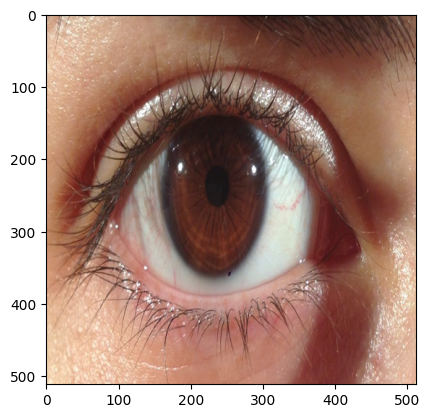

In [32]:
plt.imshow(img.permute(1,2,0))

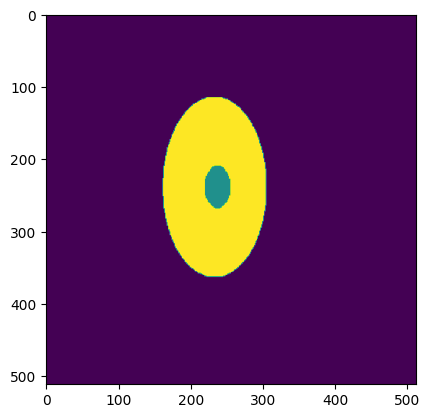

In [33]:
plt.imshow(gt.permute(1,2,0))

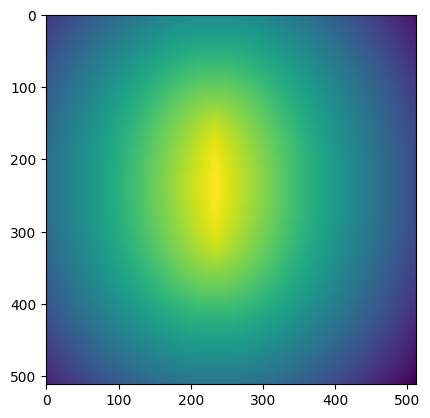

In [34]:
plt.imshow(dist_map[0])


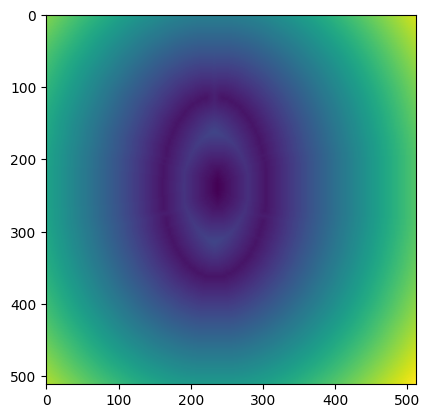

In [35]:
plt.imshow(dist_map[1])

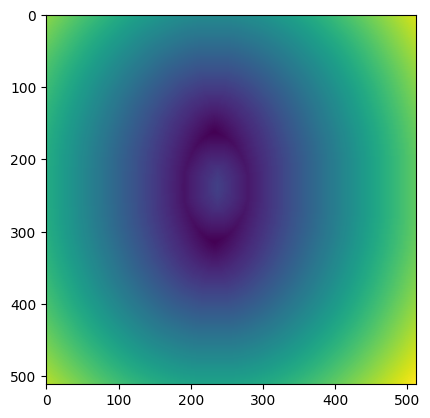

In [37]:
plt.imshow(dist_map[2])

In [170]:
print(x["images"].size())

torch.Size([3, 565, 981])


In [171]:
print(x["gt"].size())

torch.Size([1, 400, 400])


In [172]:
print(x["dist_map"].size())

torch.Size([3, 400, 400])


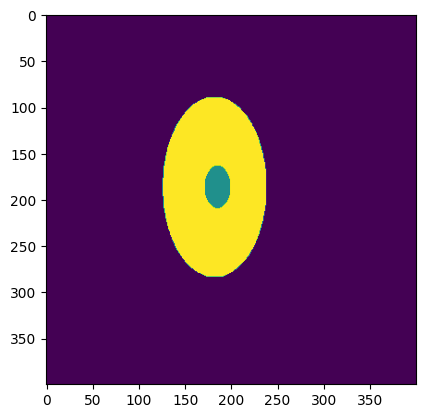

In [173]:
plt.imshow(x["gt"].permute(1,2,0))

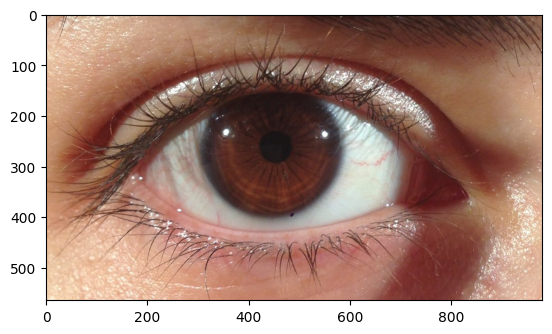

In [175]:
plt.imshow(x["images"].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


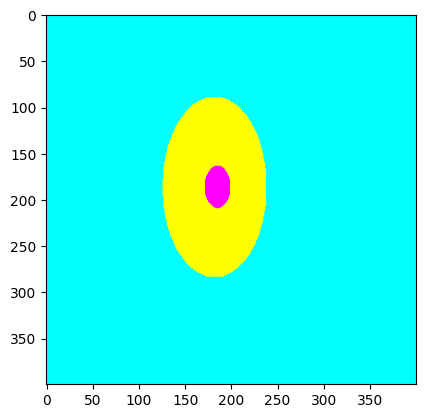

In [176]:
plt.imshow(x["dist_map"].permute(1,2,0))